In [1]:
%matplotlib nbagg
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pandas as pd
import csv
fnames = !ls *.csv

docs = []
for fname in fnames:
    with open(fname) as f:
        for doc in csv.DictReader(f,delimiter=';'):
            doc = {k.strip().lower().replace(' ', '_'): v.strip() for k, v in doc.iteritems()}
            doc = {k: int(v) if v.isdigit() else v for k, v in doc.iteritems()}
            docs.append(doc)

            
df = pd.DataFrame(docs)

In [3]:
from collections import defaultdict

fields = 'codigo_provincia codigo_departamento codigo_circuito'.split()
vectors = []
for group_id, locs in df.groupby(by=fields).groups.iteritems():
    vector = defaultdict(int)
    vector.update(dict(zip(fields, group_id)))
    for _, row in df.iloc[locs].iterrows():
        vector[str(row.codigo_votos)] += row.votos
    vectors.append(vector)
gdf = pd.DataFrame(vectors)
gdf.to_hdf('gdf.h5py', 'gdf')

/Library/Python/2.7/site-packages/pandas/io/pytables.py:2577: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->['codigo_circuito']]

  warnings.warn(ws, PerformanceWarning)


In [ ]:
import pandas as pd
gdf = pd.read_hdf('gdf.h5py', 'gdf')

In [4]:
gdf['diff'] = gdf['135'] - gdf['131']
gdf['total'] = sum(gdf[k] for k in '132 133 137 138 135 131'.split()) + 6

for k in '132 133 137 138 135 131'.split():
    gdf[k + "_pct"] = (gdf[k] + 1.0) / gdf.total
    
gdf=gdf[gdf['135'] > 0]
gdf=gdf[gdf['131'] > 0]

In [8]:
from scipy.stats import gaussian_kde

class ConditionalDistribution(object):
    def __init__(self, x1, x2, predict_resolution=100):
        """
        fits x1 | x2
        """
        self.x1 = x1
        self.x2 = x2
        self.predict_resolution = predict_resolution
        
        ymin, ymax = np.percentile(self.x2, [1, 99])
        self.y = np.linspace(ymin, ymax, predict_resolution)
        self._cache = {}
    
    def fit(self):
        self.joint_estimate = gaussian_kde(np.vstack([self.x1, self.x2]))
        self.cond_estimate = gaussian_kde(self.x2)
        return self

    def predict(self, x):
        return self.y, self.joint_estimate(np.asarray([(x, e) for e in self.y]).T) / self.cond_estimate(x)

    def sample(self, x):
        if x not in self._cache:
            y, probs = self.predict(x)
            probs = np.cumsum(probs)
            p = np.random.random() * probs[-1]
            self._cache[x] = y[probs.searchsorted(p)]
        return self._cache[x]
        
    def draw(self, resolution=100j):
        xmin, xmax = np.percentile(self.x1, [1, 99])
        ymin, ymax = np.percentile(self.x2, [1, 99])
        X, Y = np.mgrid[xmin:xmax:resolution, ymin:ymax:resolution]
        positions = np.vstack([X.ravel(), Y.ravel()])
        
        def draw_Z(Z):
            imshow(Z, interpolation='nearest', origin='lower')
            locs = np.arange(0, int(resolution.imag), int(resolution.imag) / 5)
            xticks(locs,  ['%.02f' % e for e in X[locs, 0].squeeze()])
            yticks(locs,  ['%.02f' % e for e in Y[0, locs].squeeze()])
        
        figure()
        subplot(311)
        Z = np.reshape(self.joint_estimate(positions), X.shape).T
        draw_Z(Z)

        subplot(312)
        draw_Z(Z / self.cond_estimate(Y[0]))

        subplot(313)
        plot(self.cond_estimate(Y[0]))
        


In [6]:
from collections import defaultdict

class Model(object):
    def fit(self, dfX, dfy):
        self.distrs = {}
        for predictor, x_values in dfX.iteritems():
            self.distrs[predictor] = {}
            for target, y_values in dfy.iteritems():
                self.distrs[predictor][target] = ConditionalDistribution(y_values, x_values).fit()
        return self
    
    def predict(self, dfX, df_cnt):
        res = defaultdict(int)
        for row_id, row in dfX.iterrows():
            if row_id % 100 == 0: 
                print row_id, 'of', len(dfX)
                print dict(res)
                s = sum(res.values())
                print {k: v/s for k, v in res.iteritems()}
                
            for predictor, x_value in row.iteritems():
                targets = {}
                for target, distr in self.distrs[predictor].iteritems():
                    y_value = distr.sample(x_value)
                    targets[target] = y_value

                s = sum(targets.values())
                for target, value in targets.iteritems():
                    pred = df_cnt.iloc[row_id][predictor.replace('_pct', '')] * value / s
                    if pd.isnull(pred): 1/0
                    res[target] += pred 

        return dict(res)


<IPython.core.display.Javascript object>


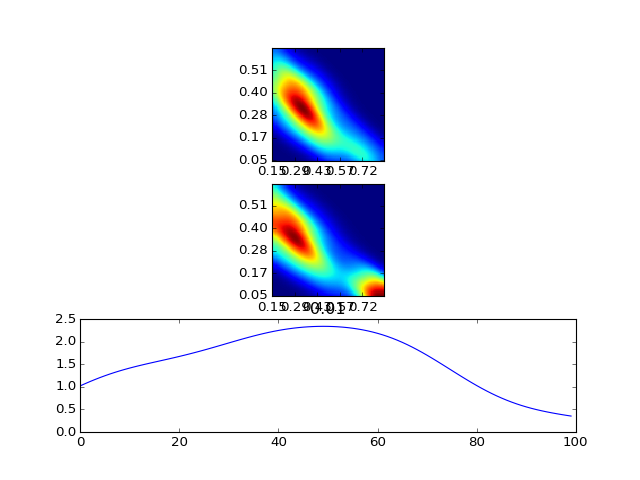

<IPython.core.display.Javascript object>


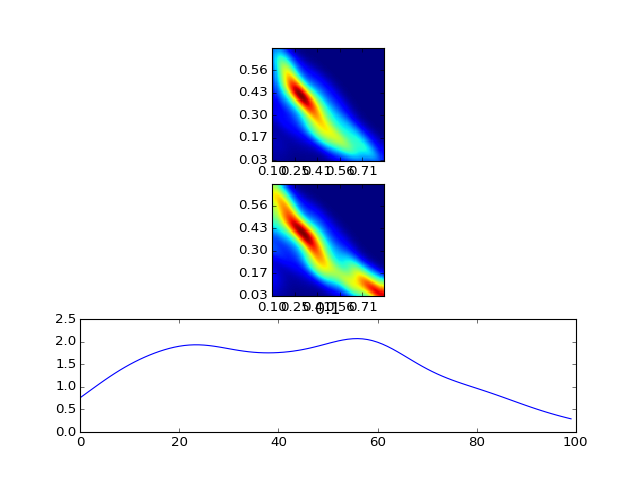

<IPython.core.display.Javascript object>


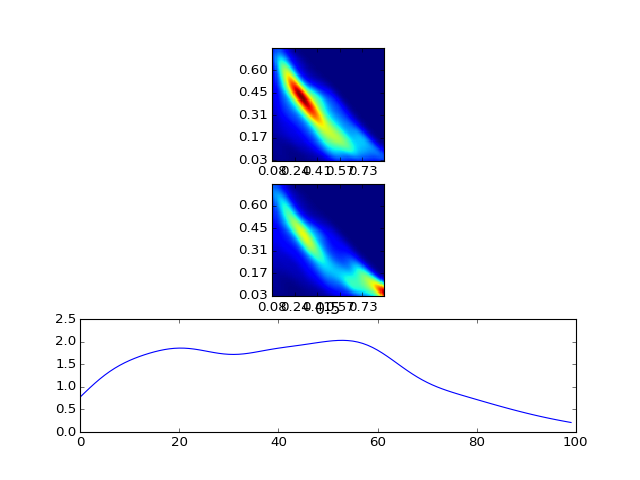

<IPython.core.display.Javascript object>


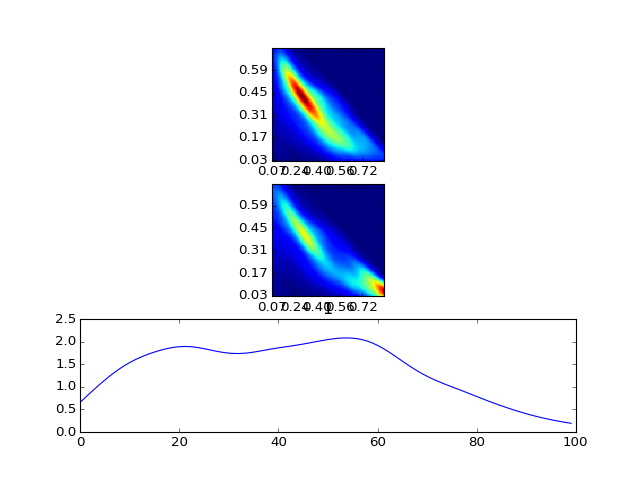

In [9]:
for t in [0.01, 0.1, 0.5, 1]:
    mask = np.random.random_sample(len(gdf)) < t
    cd = ConditionalDistribution(gdf['131_pct'][mask], gdf['135_pct'][mask]).fit()
    cd.draw(100j)
    title(str(t))

In [10]:
dfX = gdf['132_pct 133_pct 137_pct 138_pct'.split()]
df_cnt = gdf['132 133 137 138'.split()]
dfy = gdf['131_pct 135_pct'.split()]

mask = np.random.random_sample(len(gdf)) < 10
model = Model().fit(dfX[mask], dfy[mask])

In [11]:
d = model.predict(dfX, df_cnt)

0 of 4344
{}
{}
100 of 4344
{'135_pct': 57805.489201228054, '131_pct': 57947.510798771931}
{'135_pct': 0.49938653167717523, '131_pct': 0.50061346832282483}
200 of 4344
{'135_pct': 142798.12395089684, '131_pct': 162361.87604910313}
{'135_pct': 0.4679450909388414, '131_pct': 0.53205490906115849}
300 of 4344
{'135_pct': 210130.2967996042, '131_pct': 228607.7032003958}
{'135_pct': 0.47894255067854663, '131_pct': 0.52105744932145337}
400 of 4344
{'135_pct': 290997.25590141397, '131_pct': 304312.74409858609}
{'135_pct': 0.48881634090039472, '131_pct': 0.51118365909960539}
500 of 4344
{'135_pct': 350516.43694689375, '131_pct': 363109.56305310625}
{'135_pct': 0.49117666249112807, '131_pct': 0.50882333750887199}
600 of 4344
{'135_pct': 435419.77406814555, '131_pct': 446388.22593185445}
{'135_pct': 0.49378070290601306, '131_pct': 0.50621929709398694}
700 of 4344
{'135_pct': 503884.47694148071, '131_pct': 523455.52305851929}
{'135_pct': 0.49047489335709765, '131_pct': 0.50952510664290229}


KeyboardInterrupt: 

In [ ]:
debug

In [ ]:
for predictor, d in model.iteritems():
    figure()
    d.plot()

In [ ]:
from collections import defaultdict
ans = defaultdict(int)
discarded = 0
for _, row in gdf.iterrows():
    for predictor, f in row.iteritems():
        if predictor not in model: continue
        f = int(f * 40) / 40.0
        cnt = row[predictor.replace('_pct', '')]
        if f not in model[predictor]: 
            discarded += cnt
            continue
            
        p = 1 / (np.exp(model[predictor][f]) + 1)
        assert p <= 1
        ans['131'] += p * cnt
        ans['135'] += (1 - p) * cnt
#         ans[target] += target_model[cnt] * cnt 


In [ ]:
ans['131'] += gdf['131'].sum()
ans['135'] += gdf['135'].sum()

In [ ]:
s = sum(ans.values())
{k: v/s for k, v in ans.iteritems()}

In [ ]:
ans['135']

In [ ]:
s = 0
for k in [u'131', u'132', u'133', u'135', u'137', u'138']:
    s+= gdf[k].sum()
s

In [ ]:
fields = [u'132_pct', u'133_pct', u'137_pct', u'138_pct']
X = gdf[fields]


In [ ]:
figure()
gdf.total.hist(bins=30)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE().fit(X)